In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 24s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_49.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(49, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.393009,92.970212,97.763269,94.541453,99.476819,95.628952
공시지가(만원),73.508770,78.046967,77.053892,77.339099,78.071045,76.803955
year_linear,63.289143,63.791101,64.826220,65.291197,66.226141,64.684760
건축년도,48.072768,48.124225,44.408600,50.522751,46.816994,47.589068
전용면적,35.974530,36.851112,38.525341,41.258425,39.445768,38.411035


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.393009,92.970212,97.763269,94.541453,99.476819,95.628952
공시지가(만원),73.508770,78.046967,77.053892,77.339099,78.071045,76.803955
year_linear,63.289143,63.791101,64.826220,65.291197,66.226141,64.684760
건축년도,48.072768,48.124225,44.408600,50.522751,46.816994,47.589068
전용면적,35.974530,36.851112,38.525341,41.258425,39.445768,38.411035
ynorm,30.029532,30.852358,30.496766,31.603923,32.513589,31.099234
xy,20.882857,22.626086,20.286549,22.215516,22.479195,21.698041
x_2nd,19.894753,18.595029,20.242286,20.321404,19.468797,19.704454
주건축물수,13.274715,12.656716,13.308718,13.685322,13.623797,13.309854
층mean,11.218907,10.167298,10.451759,10.610211,11.371905,10.764016


In [14]:
top_47_df = shap_summary_df.iloc[:47,:]
print(top_47_df.shape)

(47, 6)


In [15]:
top_47_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.393009,92.970212,97.763269,94.541453,99.476819,95.628952
공시지가(만원),73.508770,78.046967,77.053892,77.339099,78.071045,76.803955
year_linear,63.289143,63.791101,64.826220,65.291197,66.226141,64.684760
건축년도,48.072768,48.124225,44.408600,50.522751,46.816994,47.589068
전용면적,35.974530,36.851112,38.525341,41.258425,39.445768,38.411035


In [16]:
top_47_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
지붕_평지붕_fraction,2.591576,2.523518,2.524863,2.529355,2.632301,2.560322
건물나이,2.485835,2.277983,2.291723,2.459002,2.442011,2.391310
부속건축물수,2.092888,1.975542,1.873855,2.902222,2.974744,2.363850
지형높이,2.205849,2.268629,2.204233,2.856584,2.267813,2.360622
옥외자주식대수,1.985050,2.294078,2.312445,2.426710,2.534514,2.310559
month_sin,2.342964,2.205900,2.023633,2.372322,2.179880,2.224940
층min,2.343189,2.308196,2.075596,2.091528,2.100456,2.183793
(한강)폐기물매립시설_설치제한지역,2.086028,2.011411,2.067582,1.914450,2.094921,2.034878
공원,2.118352,2.087571,1.930730,1.993272,1.819728,1.989931
지형형상,1.349236,1.357552,1.291348,1.316991,1.370199,1.337065


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_47_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 52)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,아파트지구,xnorm,호수대비연면적,호수대비부속건축물면적,옥내자주식대수,층,총호수,호수대비주차수,y_2nd,용도지역명1,층norm,지구단위계획구역,가축사육제한구역,도로접면,부속건축물면적,지붕_평지붕_fraction,건물나이,부속건축물수,지형높이,옥외자주식대수,month_sin,층min,(한강)폐기물매립시설_설치제한지역,공원,지형형상,y_cos,y_sin,x_sin,x_cos,상대정화구역,정비구역,제1종지구단위계획구역,제3종일반주거지역,중점경관관리구역,총외필지수,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0,0.0,1.0,0,0.0,0,0.0,-0.866025,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,0,0,0,0,0,1.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,2,54.0,0.0,4.094180e+07,0,0.222222,0,0,0,0.0,1.0,0,0.0,0,0.0,-0.500000,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,0,0,0,0,0,1.0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,4,54.0,0.0,4.094180e+07,0,0.444444,0,0,0,0.0,1.0,0,0.0,0,0.0,0.000000,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,0,0,0,0,0,1.0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,9,54.0,0.0,4.094180e+07,0,1.000000,0,0,0,0.0,1.0,0,0.0,0,0.0,0.866025,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,0,0,0,0,0,1.0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,0,5579.095707,98.537963,0.0,0.0,1,54.0,0.0,4.094180e+07,0,0.111111,0,0,0,0.0,1.0,0,0.0,0,0.0,-0.866025,9.0,0,0,0,0.390815,-0.920469,-0.364267,0.931294,0,0,0,0,0,1.0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

17

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 47)
y dist plot


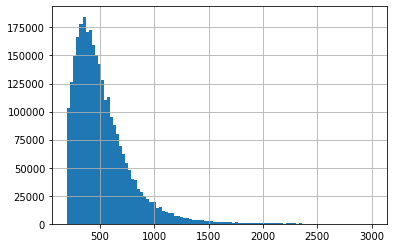

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5963
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 47


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.7018
[150]	valid_0's huber: 58.6015
[200]	valid_0's huber: 54.893
[250]	valid_0's huber: 52.3548
[300]	valid_0's huber: 50.6478
[350]	valid_0's huber: 49.3351
[400]	valid_0's huber: 48.3069
[450]	valid_0's huber: 47.3765
[500]	valid_0's huber: 46.615
[550]	valid_0's huber: 45.875
[600]	valid_0's huber: 45.2206
[650]	valid_0's huber: 44.6575
[700]	valid_0's huber: 44.1621
[750]	valid_0's huber: 43.6832
[800]	valid_0's huber: 43.2417
[850]	valid_0's huber: 42.8431
[900]	valid_0's huber: 42.4471
[950]	valid_0's huber: 42.0935
[1000]	valid_0's huber: 41.7833
[1050]	valid_0's huber: 41.4827
[1100]	valid_0's huber: 41.1958
[1150]	valid_0's huber: 40.9327
[1200]	valid_0's huber: 40.6883
[1250]	valid_0's huber: 40.4357
[1300]	valid_0's huber: 40.1927
[1350]	valid_0's huber: 39.9981
[1400]	valid_0's huber: 39.8093
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


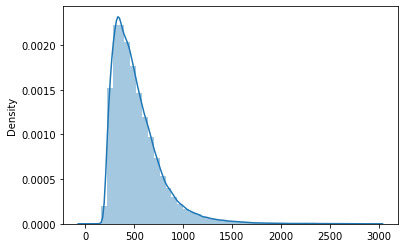

Fold 0 end
Fold 1 start
(2926581, 47)
y dist plot


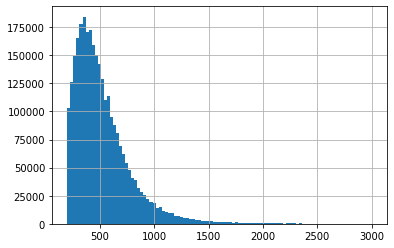

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5964
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 47


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 65.0569
[150]	valid_0's huber: 58.8494
[200]	valid_0's huber: 55.1127
[250]	valid_0's huber: 52.546
[300]	valid_0's huber: 50.7581
[350]	valid_0's huber: 49.4441
[400]	valid_0's huber: 48.3176
[450]	valid_0's huber: 47.3952
[500]	valid_0's huber: 46.5858
[550]	valid_0's huber: 45.821
[600]	valid_0's huber: 45.1184
[650]	valid_0's huber: 44.6111
[700]	valid_0's huber: 44.1031
[750]	valid_0's huber: 43.6351
[800]	valid_0's huber: 43.169
[850]	valid_0's huber: 42.7187
[900]	valid_0's huber: 42.3885
[950]	valid_0's huber: 42.0554
[1000]	valid_0's huber: 41.762
[1050]	valid_0's huber: 41.4202
[1100]	valid_0's huber: 41.1604
[1150]	valid_0's huber: 40.9265
[1200]	valid_0's huber: 40.7075
[1250]	valid_0's huber: 40.4578
[1300]	valid_0's huber: 40.2412
[1350]	valid_0's huber: 40.0265
[1400]	valid_0's huber: 39.8277
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


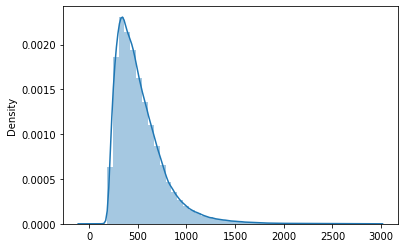

Fold 1 end
Fold 2 start
(2926581, 47)
y dist plot


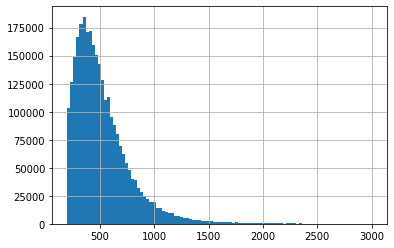

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5965
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 47


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.7014
[150]	valid_0's huber: 58.4006
[200]	valid_0's huber: 54.8355
[250]	valid_0's huber: 52.378
[300]	valid_0's huber: 50.4747
[350]	valid_0's huber: 49.0334
[400]	valid_0's huber: 47.9328
[450]	valid_0's huber: 47.0029
[500]	valid_0's huber: 46.1858
[550]	valid_0's huber: 45.5007
[600]	valid_0's huber: 44.9336
[650]	valid_0's huber: 44.4088
[700]	valid_0's huber: 43.8993
[750]	valid_0's huber: 43.4505
[800]	valid_0's huber: 43.0345
[850]	valid_0's huber: 42.6925
[900]	valid_0's huber: 42.3417
[950]	valid_0's huber: 41.9745
[1000]	valid_0's huber: 41.6968
[1050]	valid_0's huber: 41.4429
[1100]	valid_0's huber: 41.1801
[1150]	valid_0's huber: 40.9585
[1200]	valid_0's huber: 40.7014
[1250]	valid_0's huber: 40.4977
[1300]	valid_0's huber: 40.3052
[1350]	valid_0's huber: 40.1206
[1400]	valid_0's huber: 39.9125
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


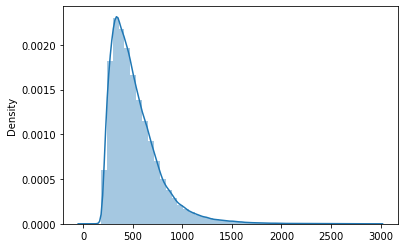

Fold 2 end
Fold 3 start
(2926581, 47)
y dist plot


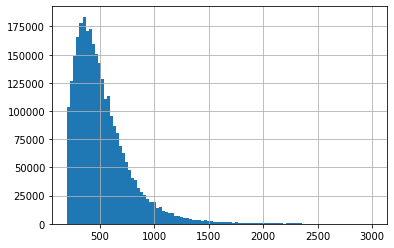

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5958
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 47


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.8587
[150]	valid_0's huber: 58.6779
[200]	valid_0's huber: 55.0654
[250]	valid_0's huber: 52.4803
[300]	valid_0's huber: 50.7246
[350]	valid_0's huber: 49.3307
[400]	valid_0's huber: 48.1707
[450]	valid_0's huber: 47.1744
[500]	valid_0's huber: 46.3638
[550]	valid_0's huber: 45.6366
[600]	valid_0's huber: 44.9465
[650]	valid_0's huber: 44.371
[700]	valid_0's huber: 43.8218
[750]	valid_0's huber: 43.3497
[800]	valid_0's huber: 42.9366
[850]	valid_0's huber: 42.5265
[900]	valid_0's huber: 42.1374
[950]	valid_0's huber: 41.8032
[1000]	valid_0's huber: 41.5485
[1050]	valid_0's huber: 41.2767
[1100]	valid_0's huber: 41.0165
[1150]	valid_0's huber: 40.7788
[1200]	valid_0's huber: 40.5529
[1250]	valid_0's huber: 40.3586
[1300]	valid_0's huber: 40.1502
[1350]	valid_0's huber: 39.9728
[1400]	valid_0's huber: 39.7915
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


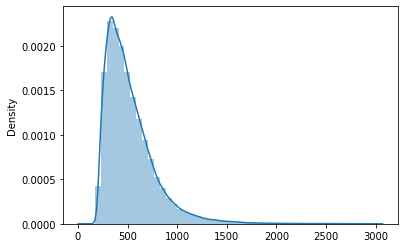

Fold 3 end
Fold 4 start
(2926581, 47)
y dist plot


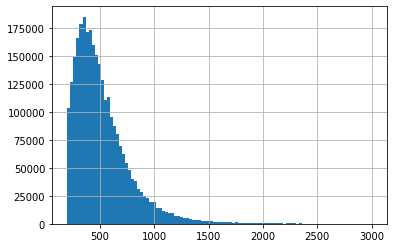

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5959
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 47


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.6848
[150]	valid_0's huber: 58.7665
[200]	valid_0's huber: 55.1638
[250]	valid_0's huber: 52.7975
[300]	valid_0's huber: 51.0177
[350]	valid_0's huber: 49.7069
[400]	valid_0's huber: 48.4864
[450]	valid_0's huber: 47.4176
[500]	valid_0's huber: 46.5975
[550]	valid_0's huber: 45.8381
[600]	valid_0's huber: 45.2333
[650]	valid_0's huber: 44.6371
[700]	valid_0's huber: 44.0677
[750]	valid_0's huber: 43.5592
[800]	valid_0's huber: 43.1613
[850]	valid_0's huber: 42.7875
[900]	valid_0's huber: 42.3595
[950]	valid_0's huber: 42.0377
[1000]	valid_0's huber: 41.7285
[1050]	valid_0's huber: 41.4288
[1100]	valid_0's huber: 41.1336
[1150]	valid_0's huber: 40.8319
[1200]	valid_0's huber: 40.5701
[1250]	valid_0's huber: 40.3425
[1300]	valid_0's huber: 40.1231
[1350]	valid_0's huber: 39.917
[1400]	valid_0's huber: 39.7378
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


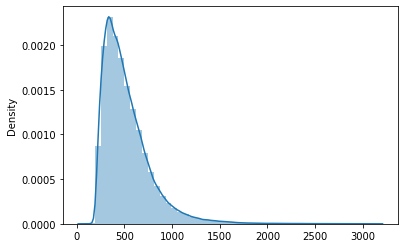

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_47_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

64.8221338225542

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_47.csv')

In [34]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.820716,89.995787,92.115376,95.384442,95.617199,93.586704
공시지가(만원),79.340233,76.859986,77.567496,77.289188,75.445312,77.300443
year_linear,64.413585,62.359725,64.603483,64.775827,64.484595,64.127443
건축년도,46.969523,47.437061,48.129198,47.850436,47.957250,47.668693
전용면적,40.870716,37.256955,40.681768,38.357426,40.770922,39.587557
ynorm,31.142993,29.728605,31.683667,30.563589,30.367021,30.697175
xy,21.590209,20.801011,19.650856,21.500984,22.787364,21.266085
x_2nd,19.079826,18.730173,18.464523,18.489412,20.771321,19.107051
주건축물수,14.165298,12.910095,13.370128,13.578644,12.900315,13.384896
층mean,10.314252,12.640504,11.205216,9.527042,12.003689,11.138140


In [35]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
y_cos,1.357297,1.189329,1.174919,1.253637,1.235030,1.242042
y_sin,1.353938,1.158763,1.100208,1.322050,1.327964,1.252585
x_sin,1.331686,1.119905,1.059791,1.298107,1.351513,1.232200
x_cos,1.254986,1.108579,1.054321,1.216500,1.370573,1.200992
상대정화구역,1.123456,1.397202,1.132358,1.059610,1.008033,1.144132
정비구역,1.103800,1.009617,0.961062,1.195652,1.450369,1.144100
제1종지구단위계획구역,1.043388,0.907047,1.139775,1.091433,1.060200,1.048369
제3종일반주거지역,1.167084,0.968683,1.109497,1.145217,1.055691,1.089234
중점경관관리구역,0.997017,1.037872,0.979041,0.926502,0.926234,0.973333
총외필지수,0.862401,0.755720,0.913758,0.913838,0.909598,0.871063


In [33]:
#